In [2]:
with open("../resources/names.txt", "r") as r:
    names = ["." + f + "." for f in r.read().split()]

## embedding

our bigram embedding is very simple - letters to numbers

so to go from a letter to its represenation we just create a map

and to go back from the embedding to a letter we just reverse

In [3]:
import string
letters = [l for l in string.ascii_lowercase]

itos = {0: "."}
stoi = {".": 0}

for i, l in enumerate(letters):
    offset = i+1
    stoi[l] = offset
    itos[offset] = l

stoi["a"], itos[1]

(1, 'a')

## training set

our model should take an input letter and predict the next letter so 
for each name we want to go letter by letter, each time the following letter is the prediction


In [4]:
def train(examples, n=-1):
    if n == -1:
        n = len(examples)
    xs, ys = [], []
    for example in examples[:n]:
        em = [stoi[c] for c in example] 
        for x, y in zip(em, em[1:]):
            xs.append(x)
            ys.append(y)
    return xs, ys 

In [5]:
train(names[:6], 1), names[0]

(([0, 5, 13, 13, 1], [5, 13, 13, 1, 0]), '.emma.')

so the first name '.emma.' 
has multiple traning examples in it

it predicts:
* 'e' to follow '.' 
* 'm' to follow 'e'

etc

train allows us to call a subset of the input collection or by default all of them

In [6]:
train(names, 2), names[:2]

(([0, 5, 13, 13, 1, 0, 15, 12, 9, 22, 9, 1],
  [5, 13, 13, 1, 0, 15, 12, 9, 22, 9, 1, 0]),
 ['.emma.', '.olivia.'])

## Torch

now lets start looking at the in terms of torch tensors

In [7]:
import torch
import torch.nn.functional as F

In [8]:
def torchifi(examples, n=-1, one_hot = True):
    xs, ys = train(examples, n)
    xs = torch.tensor(xs)
    ys = torch.tensor(ys)
    if one_hot:
        return F.one_hot(xs, num_classes=27).float(), F.one_hot(ys, num_classes=27).float()
    else:
        return xs, ys

In [9]:
xsoh, ysoh = torchifi(names, 1)
xsoh

tensor([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0.]])

## The neural net

now our input vectors are of size n * 27 we need the input layer to take the 27 (one hot) inputs and process them

so the first layer needs to be 27 * o

lets start with 27 * 1 

i.e a single neuron

In [10]:
W = torch.randn(27, 1)
o = xsoh @ W
o, o.shape

(tensor([[-1.4060],
         [ 0.3356],
         [ 2.4275],
         [ 2.4275],
         [ 0.9721]]),
 torch.Size([5, 1]))

## Input, Output

so if we have a 5 * 27 input we get a 5, 1 output

we'll need an output with a dimension of 27 at some stage to compare to our ys

we don't need to do that here - we could have another layer going 1 to 27 or change W 27 * 5 (for example) and  have intermediate layers that reshape until we need that output layer

but because we aren't doing anything clever here, let's just compress everything and have W as a 27x27 for simplicity

In [11]:
g = torch.Generator().manual_seed(2147483647)
# just use a fixed generator for the moment so we can check valaues
W = torch.randn(27, 27, generator=g)

In [12]:
logits = xsoh @ W
logits.shape

torch.Size([5, 27])

## Almost ready

we now have a 5 x 27 output

lets take a moment to remember what we're trying to do, because the tensors, though making things computationally easy, maybe aren't so obvious

we had 5 input letters and we were trying to predict good output letters for each of them

now we have 5 answers and we want to evaluate how good they are

we started with "." and from our one name we want the first output to be "e" (at the momenet all names are emma so every name starts with an e)

why did we call the output 'logits'?

basically because we're going to .exp() it to get nicer values...

next softmax the logits

In [13]:
counts = logits.exp()
probs = counts / counts.sum(1, keepdim=True)
probs[0]

tensor([0.0607, 0.0100, 0.0123, 0.0042, 0.0168, 0.0123, 0.0027, 0.0232, 0.0137,
        0.0313, 0.0079, 0.0278, 0.0091, 0.0082, 0.0500, 0.2378, 0.0603, 0.0025,
        0.0249, 0.0055, 0.0339, 0.0109, 0.0029, 0.0198, 0.0118, 0.1537, 0.1459])

In [14]:
probs.shape, ysoh.shape

(torch.Size([5, 27]), torch.Size([5, 27]))

note that we estimate loss as a mean() over the *entire* 'batch' that we train with

In [15]:
log_likelihood = -(ysoh * probs).sum(1).log().mean()
log_likelihood

tensor(3.7693)

## OK lets actually set things up 

get a nn, a forward pass and a backward pass

In [16]:
W = torch.randn(27, 27, requires_grad=True)

at the moment our weights have no gradients

In [17]:
W.grad

In [18]:
def learn(xs, ys):
    logits = xs @ W
    ##softmax 
    probs = logits.exp()
    probs = probs / probs.sum(1, keepdim=True)
    # i use 1-hot ys, does this matter?
    loss = -(ys * probs).sum(1).log().mean()
    W.grad = None
    loss.backward()
    W.data -= learning_rate * W.grad
    return loss.data

In [19]:
xsoh, ysoh = torchifi(names, 2)

In [21]:
learning_rate = 1
learn(xsoh, ysoh)
W.grad[0]

tensor([ 0.0035,  0.0026,  0.0048,  0.0018,  0.0017, -0.0798,  0.0010,  0.0041,
         0.0073,  0.0086,  0.0048,  0.0021,  0.0019,  0.0003,  0.0051, -0.0653,
         0.0014,  0.0016,  0.0059,  0.0522,  0.0099,  0.0034,  0.0046,  0.0039,
         0.0061,  0.0037,  0.0028])

## sanity check

if we feed 'emma' into the network multiple times we should get 'emma', 'ema', 'emmmma' etc out

i.e it should always start with 'e' and end with 'a'

In [22]:
W = torch.randn(27, 27, requires_grad=True)
xsoh, ysoh = torchifi(names, 1)
learning_rate = 1

for i in range(1600):
    show_loss = learn(xsoh, ysoh)
    if i % 400 == 0:
        print(show_loss)

tensor(4.8068)
tensor(0.2901)
tensor(0.2834)
tensor(0.2813)


## generate names

to generate names we start with the '.' symbol and loop until we get the '.' symbol again

In [23]:
def generate_names(num_names):
    for i in range(num_names):
        out = []
        ix = 0
        while True:
            xenc = F.one_hot(torch.tensor([ix]), num_classes=27).float()
            logits = xenc @ W
            counts = logits.exp()
            p = counts / counts.sum(1, keepdim=True)
    
            # print(p)
            ## torch.multinomial pulls out an index in p (num_samples=1) by sampling from the elements in p according to their probabilities 
            ## (p is normalized in the softmax above)
            ix = torch.multinomial(p, num_samples=1).item()
    
            # print(ix)
            if ix == 0:
                break
            out.append(itos[ix])
            
    
        print("".join(out))

generate_names(5)

emmmmma
emma
emmmma
emma
emmma


If we look at the weights we can see the 'm' is the only letter where it's not sure where to go

at row[13] we have 2 entries - 1 at 'a' and the other at 'm'

In [25]:
stoi["m"]

13

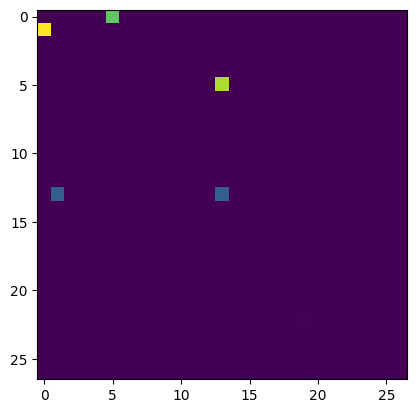

In [24]:
import matplotlib.pyplot as plt
wplot = W.exp().data
plt.imshow(wplot)

## now lets train a network that can generate names

In [26]:
W = torch.randn(27, 27, requires_grad=True)

xsoh, ysoh = torchifi(names)

xsoh.shape, ysoh.shape

(torch.Size([228146, 27]), torch.Size([228146, 27]))

In [27]:
learning_rate = 50
for i in range(3000):
    show_loss = learn(xsoh, ysoh)
    if i % 300 == 0:
        print(show_loss)

tensor(3.7490)
tensor(2.4592)
tensor(2.4563)
tensor(2.4555)
tensor(2.4551)
tensor(2.4548)
tensor(2.4547)
tensor(2.4546)
tensor(2.4545)
tensor(2.4545)


an adaptive learning rate doesn't seem to make any difference, just slow down learning...

In [28]:
W = torch.randn(27, 27, requires_grad=True)
learning_rate = 50
for i in range(0, 3000):
    show_loss = learn(xsoh, ysoh)
    if i % 300 == 0:
        print(show_loss)
        if i != 0:
            learning_rate *= .9

tensor(3.8117)
tensor(2.4592)
tensor(2.4565)
tensor(2.4557)
tensor(2.4553)
tensor(2.4551)
tensor(2.4549)
tensor(2.4548)
tensor(2.4547)
tensor(2.4547)


maybe its even easier to see if we don't break up the process

In [29]:
W = torch.randn(27, 27, requires_grad=True)
xs, ys = torchifi(names)
learning_rate = 50
i = 0

for i in range(3000):
    logits = xs @ W
    ##softmax 
    probs = logits.exp()
    probs = probs / probs.sum(1, keepdim=True)
    # use 1hot ys to isolate loss
    loss = -(ys * probs).sum(1).log().mean()
    
    W.grad = None
    loss.backward()
    W.data -= learning_rate * W.grad

    if i % 300 == 0:
        print(loss.data)

tensor(3.6531)
tensor(2.4592)
tensor(2.4563)
tensor(2.4555)
tensor(2.4551)
tensor(2.4548)
tensor(2.4547)
tensor(2.4546)
tensor(2.4545)
tensor(2.4545)


## the same as a bigram count model

our W matrix after training should look almost identical to a 27x27 count matrix formed from our names

In [30]:
Wb = torch.zeros(27, 27)

xbs, ybs = train(names)

for x, y in zip(xbs, ybs):
    Wb[x,y]+=1

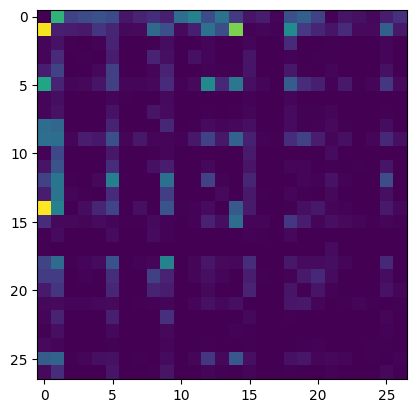

In [31]:
plt.imshow(Wb)

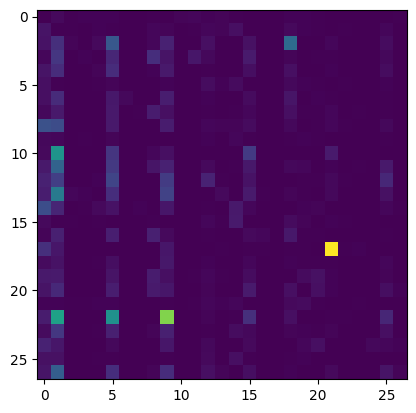

In [364]:
wplot = W.exp().data
plt.imshow(wplot)

## Similar...

but not exact, I was expecting it to be closer 

but maybe its as much down to how we calculate the image from the data as our logit counts are not the same as real counts

In [36]:
generate_names(15)

ahyn
jhenonertareyn
ron
man
t
aamalem
jon
cenghisea
rove
kllen
zaca
tayaubreawakylieylonavis
de
drislyathrio
jamanollyilelan


## some of those are even real names